# Тренировка нейросети 1-го этапа по детекции пиктограмм на yandex smartcaptcha

**Описание:**

Обучаемая нейросеть должна классифицировать пиктограммы из нижней части капчи. 15 классов.

In [ ]:
import pickle
import pandas as pd
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import time

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, Dataset

изменил нативное значение rescale_size на 227 для alexnet

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 227
DEVICE = torch.device("cuda")

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Aug 28 16:59:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip /content/gdrive/MyDrive/Images/Smartsolver_Dataset/icons_5.zip

Archive:  /content/gdrive/MyDrive/Images/Smartsolver_Dataset/icons_5.zip
   creating: testset/
   creating: testset/testset/
  inflating: testset/testset/img0.jpg  
  inflating: testset/testset/img1.jpg  
  inflating: testset/testset/img10.jpg  
  inflating: testset/testset/img11.jpg  
  inflating: testset/testset/img12.jpg  
  inflating: testset/testset/img13.jpg  
  inflating: testset/testset/img14.jpg  
  inflating: testset/testset/img15.jpg  
  inflating: testset/testset/img16.jpg  
  inflating: testset/testset/img17.jpg  
  inflating: testset/testset/img18.jpg  
  inflating: testset/testset/img19.jpg  
  inflating: testset/testset/img2.jpg  
  inflating: testset/testset/img20.jpg  
  inflating: testset/testset/img21.jpg  
  inflating: testset/testset/img22.jpg  
  inflating: testset/testset/img23.jpg  
  inflating: testset/testset/img24.jpg  
  inflating: testset/testset/img25.jpg  
  inflating: testset/testset/img26.jpg  
  inflating: testset/testset/img27.jpg  
  inflating: test

In [ ]:
!ls train
!ls testset

captcha_dataset  classes.txt
testset


In [ ]:
class CaptchaDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False): # Функция для просмотра
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/captcha_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = CaptchaDataset(val_files, mode='val')
train_dataset = CaptchaDataset(train_files, mode='train')

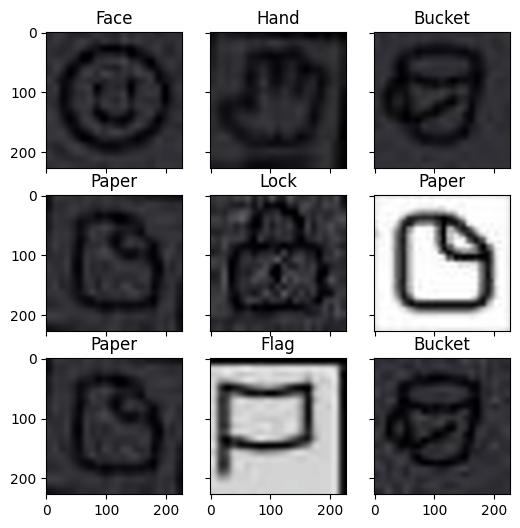

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(6, 6), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,300))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=15):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 2048),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(1024, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    start = time.time()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            start_epoch = time.time()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            final_epoch = time.time()
            print(f"На {epoch + 1} эпоху потрачено {round((float(final_epoch) - float(start_epoch)), 1)} секунд")
    final = time.time()
    print(f"Всего потрачено {round((float(final) - float(start)), 1)} секунд")
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
alexnet = AlexNet(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(alexnet)

we will classify :15
AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_feature

In [ ]:
if val_dataset is None:
    val_dataset = CaptchaDataset(val_files, mode='val')

train_dataset = CaptchaDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=alexnet, epochs=12, batch_size=5)

epoch:   0%|          | 0/12 [00:00<?, ?it/s]

loss 3.1492986806233723


epoch:   8%|▊         | 1/12 [00:14<02:41, 14.64s/it]


Epoch 001 train_loss: 3.1493     val_loss 2.7164 train_acc 0.0622 val_acc 0.0667
На 1 эпоху потрачено 14.7 секунд
loss 2.449934658474392


epoch:  17%|█▋        | 2/12 [00:21<01:39,  9.94s/it]


Epoch 002 train_loss: 2.4499     val_loss 1.7985 train_acc 0.1547 val_acc 0.3600
На 2 эпоху потрачено 6.6 секунд
loss 1.5715356027045184


epoch:  25%|██▌       | 3/12 [00:28<01:17,  8.57s/it]


Epoch 003 train_loss: 1.5715     val_loss 2.0830 train_acc 0.4836 val_acc 0.4613
На 3 эпоху потрачено 6.9 секунд
loss 1.4320531759776673


epoch:  33%|███▎      | 4/12 [00:34<01:01,  7.64s/it]


Epoch 004 train_loss: 1.4321     val_loss 1.4673 train_acc 0.5413 val_acc 0.4960
На 4 эпоху потрачено 6.2 секунд
loss 0.7093640353507953


epoch:  42%|████▏     | 5/12 [00:41<00:52,  7.50s/it]


Epoch 005 train_loss: 0.7094     val_loss 0.4141 train_acc 0.7867 val_acc 0.8507
На 5 эпоху потрачено 7.3 секунд
loss 0.5446910560271807


epoch:  50%|█████     | 6/12 [00:47<00:42,  7.09s/it]


Epoch 006 train_loss: 0.5447     val_loss 0.1745 train_acc 0.8720 val_acc 0.9280
На 6 эпоху потрачено 6.3 секунд
loss 0.12869125089068573


epoch:  58%|█████▊    | 7/12 [00:54<00:34,  6.99s/it]


Epoch 007 train_loss: 0.1287     val_loss 0.0377 train_acc 0.9573 val_acc 0.9840
На 7 эпоху потрачено 6.8 секунд
loss 0.023830358478567713


epoch:  67%|██████▋   | 8/12 [01:01<00:27,  6.77s/it]


Epoch 008 train_loss: 0.0238     val_loss 0.0193 train_acc 0.9911 val_acc 0.9947
На 8 эпоху потрачено 6.3 секунд
loss 0.007191175573921337


epoch:  75%|███████▌  | 9/12 [01:07<00:20,  6.80s/it]


Epoch 009 train_loss: 0.0072     val_loss 0.0055 train_acc 0.9982 val_acc 0.9973
На 9 эпоху потрачено 6.9 секунд
loss 0.002397590207118962


epoch:  83%|████████▎ | 10/12 [01:14<00:13,  6.69s/it]


Epoch 010 train_loss: 0.0024     val_loss 0.0022 train_acc 1.0000 val_acc 1.0000
На 10 эпоху потрачено 6.4 секунд
loss 0.0004714917289837375


epoch:  92%|█████████▏| 11/12 [01:22<00:07,  7.05s/it]


Epoch 011 train_loss: 0.0005     val_loss 0.0007 train_acc 1.0000 val_acc 1.0000
На 11 эпоху потрачено 7.9 секунд
loss 0.0001183382421145988


epoch: 100%|██████████| 12/12 [01:28<00:00,  7.39s/it]


Epoch 012 train_loss: 0.0001     val_loss 0.0005 train_acc 1.0000 val_acc 1.0000
На 12 эпоху потрачено 6.5 секунд
Всего потрачено 88.8 секунд


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

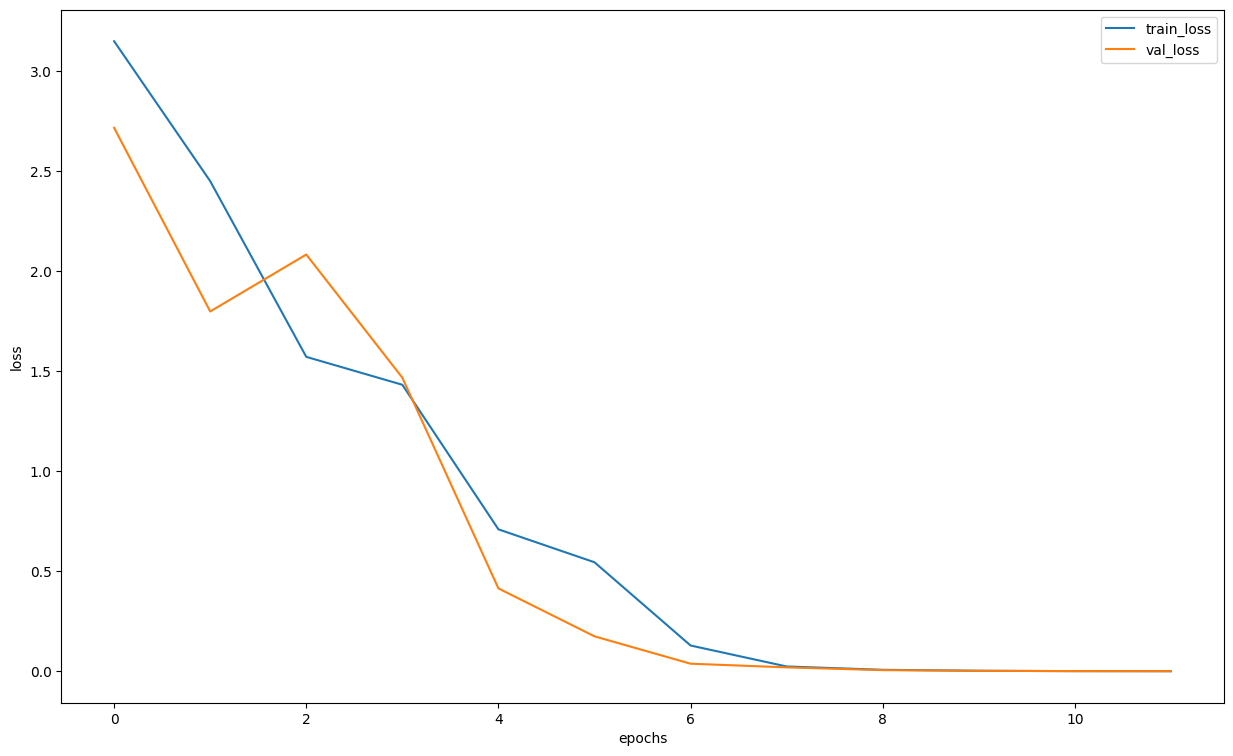

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,10))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(alexnet, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,10, 2)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(alexnet, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
test_dataset = CaptchaDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(alexnet, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit

,Id,Expected
0,img0.jpg,monitor
1,img1.jpg,bucket
2,img10.jpg,flag
3,img11.jpg,lock
4,img12.jpg,lock
...,...,...
70,img72.jpg,fire
71,img73.jpg,paper
72,img74.jpg,flag
73,img8.jpg,lock


In [ ]:
my_submit.to_csv('submission.csv', index=False)

In [ ]:
weights_dir = '/content/gdrive/MyDrive/Weights_ML/smartsolver_weights_1_2.pth'
torch.save(alexnet.state_dict(), weights_dir)